In [193]:
import matplotlib
import numpy as np
import pandas as pd
from numerapi import NumerAPI
import random
import sklearn
import lightgbm
import matplotlib.pyplot as plt
import utils
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score
from scipy import stats
import tqdm
import copy
import gc
%matplotlib inline


In [194]:
import requests
from pathlib import Path 

# Download helper functions from Learn PyTorch repo (if not already downloaded)
if Path("helper_functions.py").is_file():
  print("helper_functions.py already exists, skipping download")
else:
  print("Downloading helper_functions.py")
  request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
  with open("helper_functions.py", "wb") as f:
    f.write(request.content)

from helper_functions import plot_predictions, plot_decision_boundary

helper_functions.py already exists, skipping download


In [195]:
napi = NumerAPI()

current_round = napi.get_current_round()

# read in all of the new datas
# tournament data and example predictions change every week so we specify the round in their names
# training and validation data only change periodically, so no need to download them over again every single week
#napi.download_dataset("v4/train.parquet", "train.parquet")
df = pd.read_parquet('train.parquet')

df.head(10)

ArrowMemoryError: malloc of size 11889599168 failed

In [35]:
features = [c for c in df if c.startswith("feature")]
target = "target"
df["erano"] = df.era.astype(int)
eras = df.erano

eras.describe

<bound method NDFrame.describe of id
n003bba8a98662e4      1
n003bee128c2fcfc      1
n0048ac83aff7194      1
n00691bec80d3e02      1
n00b8720a2fdc4f2      1
                   ... 
nffc2d5e4b79a7ae    573
nffc7d24176548a4    573
nffc9844c1c7a6a9    573
nffd79773f4109bb    573
nfff87b21e4db902    573
Name: erano, Length: 606176, dtype: int32>

In [5]:
def numerai_score(y_true, y_pred):
    #device = torch.device("cpu")
    #y_pred = pd.DataFrame(y_pred.cpu().numpy())
    #y_true = pd.DataFrame(y_true.cpu().numpy())
    rank_pred = y_pred.groupby(eras).apply(lambda x: x.rank(pct=True, method="first"))
    return np.corrcoef(y_true, rank_pred)[0,1]

In [6]:
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = (correct / len(y_pred)) * 100
    return acc

In [7]:
def numerai_corr(preds, target):
  # rank (keeping ties) then Gaussianize predictions to standardize prediction distributions
  ranked_preds = (preds.rank(method="average").values - 0.5) / preds.count()
  gauss_ranked_preds = stats.norm.ppf(ranked_preds)
  
  # make targets centered around 0
  centered_target = target - target.mean()
  
  # raise both preds and target to the power of 1.5 to accentuate the tails
  preds_p15 = np.sign(gauss_ranked_preds) * np.abs(gauss_ranked_preds) ** 1.5
  target_p15 = np.sign(centered_target) * np.abs(centered_target) ** 1.5
  
  # finally return the Pearson correlation
  return np.corrcoef(preds_p15, target_p15)[0, 1]

In [8]:
#Group 1
df = df[eras.isin(np.arange(1, 575, 4))]
df1 = df[eras<=eras.median()]
df2 = df[eras>eras.median()]
eras = eras[eras.isin(np.arange(1, 575, 4))]

C:\Users\farqu\AppData\Local\Temp\ipykernel_6688\4071572803.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df1 = df[eras<=eras.median()]
C:\Users\farqu\AppData\Local\Temp\ipykernel_6688\4071572803.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df2 = df[eras>eras.median()]


In [192]:
zeros = df1[target].value_counts()[0.0]

NameError: name 'df1' is not defined

[0.5 0.5 1.  ... 0.5 0.5 0.5]
tensor([0.5000, 0.5000, 1.0000,  ..., 0.5000, 0.5000, 0.5000])


C:\Users\farqu\AppData\Local\Temp\ipykernel_6688\4157424467.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2["target1"]=np1.tolist()


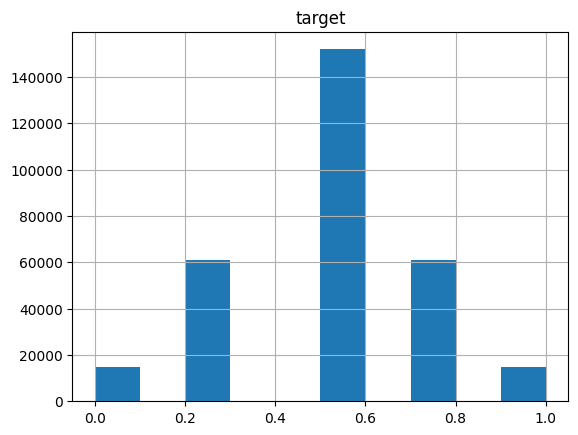

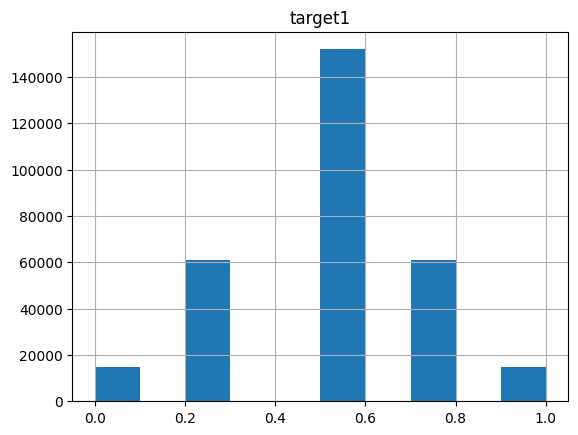

In [9]:
hist1 = df2.hist(column='target')

tensor1 = torch.tensor(df2[target].values).type(torch.FloatTensor)
print(df2[target].values)
print(tensor1)
np1 = tensor1.cpu().numpy()
df2["target1"]=np1.tolist()

hist2 = df2.hist(column='target1')

In [78]:
device = "cpu"
features_train, target_train = features_train.to(device), target_train.to(device)


features_train = torch.tensor(df1[features].values)
target_train = torch.tensor(df1[target].values).type(torch.FloatTensor).reshape(302305,1)

features_test = torch.tensor(df2[features].values)
target_test = torch.tensor(df2[target].values).type(torch.FloatTensor).reshape(303871,1)

In [132]:
device = "cuda"

In [165]:
class NumeraiV4(nn.Module):
    def __init__(self, input_features, output_features):
        super().__init__()
        self.linear_layer_stack = nn.Sequential(
            nn.Linear(in_features=input_features, out_features=64),
            nn.ReLU(),
            nn.Linear(64,32),
            nn.ReLU(),
            nn.Linear(32,16),
            nn.ReLU(),
            nn.Linear(16, out_features=output_features),
        )
        self.apply(self._init_weights)
        
    def forward(self, x):
        return self.linear_layer_stack(x)
    
    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            module.weight.data.normal_(mean=0.0, std=1.0)
            if module.bias is not None:
                module.bias.data.zero_()


In [166]:
model_0 = NumeraiV4(input_features=1191,output_features=1).to(device)
model_0

NumeraiV4(
  (linear_layer_stack): Sequential(
    (0): Linear(in_features=1191, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=32, bias=True)
    (3): ReLU()
    (4): Linear(in_features=32, out_features=16, bias=True)
    (5): ReLU()
    (6): Linear(in_features=16, out_features=1, bias=True)
  )
)

In [167]:
untrained_preds = model_0(features_train.to(device))
print(f"Length of predictions: {len(untrained_preds)}, Shape: {untrained_preds.shape}")
print(f"Length of test samples: {len(target_test)}, Shape: {target_test.shape}")
print(f"\nFirst 10 predictions:\n{untrained_preds[:10]}")
print(f"\nFirst 10 test labels:\n{target_test[:10]}")

Length of predictions: 302305, Shape: torch.Size([302305, 1])
Length of test samples: 303871, Shape: torch.Size([303871, 1])

First 10 predictions:
tensor([[2037.4331],
        [1176.0287],
        [ 624.3177],
        [1769.2830],
        [1908.6171],
        [ 916.8145],
        [ 998.7130],
        [1912.1570],
        [1793.6025],
        [2001.4690]], device='cuda:0', grad_fn=<SliceBackward0>)

First 10 test labels:
tensor([[0.5000],
        [0.5000],
        [1.0000],
        [0.5000],
        [0.7500],
        [0.5000],
        [0.5000],
        [0.2500],
        [0.2500],
        [0.5000]], device='cuda:0')


In [169]:
loss_fn = nn.MSELoss()

optimizer = torch.optim.Adam(params=model_0.parameters(), lr=0.001)

In [170]:
y_logits = model_0(features_test.to(device))[:5]
y_logits

tensor([[ 627.4161],
        [1568.2784],
        [ 855.1074],
        [ 221.2258],
        [1589.6326]], device='cuda:0', grad_fn=<SliceBackward0>)

In [179]:
device = "cuda"

features_train = features_train.to(device)
target_train = target_train.to(device)
features_test = features_test.to(device)
target_test = target_test.to(device)

train_data = features_train, target_train
features_test, target_test = features_test, target_test

train_dataset = TensorDataset(features_train, target_train)
train_loader = DataLoader(train_dataset, batch_size=10, shuffle=True)

features_train.get_device()

0

In [45]:
print(features_train.size(), target_train.size())

torch.Size([302305, 1191]) torch.Size([302305, 1])


In [180]:
torch.manual_seed(42)

batch_size = 1
batch_start = torch.arange(0, len(features_train), batch_size)
best_mse = np.inf
best_weights = None
history = []
epochs = 10

for epoch in range(epochs):
    model_0.train()
    total_loss = 0
    #with tqdm.tqdm(batch_start, unit="batch", mininterval=0, disable=True) as bar:
    for data, target_data in train_loader:
        #bar.set_description(f"Epoch {epoch}")
        #X_batch = features_train[d]
        #print(X_batch.shape)
        #y_batch = target_train[]

        y_pred = model_0(data)

        #print(y_pred.size(), target_data.size())
        loss = loss_fn(y_pred, target_data)
        #acc = accuracy_fn(y_true=target_train,y_pred=y_pred)

        optimizer.zero_grad()

        loss.backward()

        optimizer.step()

        #bar.set_postfix(mse=float(loss))
        total_loss += loss.item()
        
    average_loss = total_loss / len(train_loader)
    print(f"Epoch {epoch+1}/{epochs}, Loss: {average_loss:.4f}")
    
    model_0.eval()
    y_pred = model_0(features_test)
    mse = loss_fn(y_pred, target_test)
    mse = float(mse)
    history.append(mse)
    if mse < best_mse:
        best_mse = mse
        best_weights = copy.deepcopy(model_0.state_dict())
        
model_0.load_state_dict(best_weights)

Epoch 1/10, Loss: 1.5978
Epoch 2/10, Loss: 1.6796
Epoch 3/10, Loss: 1.4255
Epoch 4/10, Loss: 0.8610
Epoch 5/10, Loss: 1.1654
Epoch 6/10, Loss: 0.2948
Epoch 7/10, Loss: 0.0564
Epoch 8/10, Loss: 0.0500
Epoch 9/10, Loss: 0.0500
Epoch 10/10, Loss: 0.0499


<All keys matched successfully>

In [181]:
device = "cuda"
features_test, target_test = features_test.to(device), target_test.to(device)
model_0.eval()
with torch.inference_mode():
    y_preds = model_0(features_test)

In [182]:
#target_np = target_test.cpu().numpy()
preds_np = y_preds.cpu().numpy()

df2["preds"]=preds_np.tolist()
#df2["target_test"]=target_np.tolist()

corr = numerai_corr(df2["preds"], df2[target])
score = numerai_score(df2[target], df2["preds"])

C:\Users\farqu\AppData\Local\Temp\ipykernel_6688\3291735226.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2["preds"]=preds_np.tolist()
C:\Users\farqu\AppData\Local\Programs\Python\Python311\Lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\farqu\AppData\Local\Programs\Python\Python311\Lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


In [184]:
corr, score

(nan, -0.0014270811591519995)

In [185]:
#hist = df2.hist(column='target_test')

print(df2[["preds",target]])

                                 preds  target
id                                            
n000381ad0c8af9b  [0.5005451440811157]    0.50
n000ac54b6e92b06  [0.5005451440811157]    0.50
n002da3f2943306f  [0.5005451440811157]    1.00
n003ce01108ee7fe  [0.5005451440811157]    0.50
n004a5425ef72d68  [0.5005451440811157]    0.75
...                                ...     ...
nffc2d5e4b79a7ae  [0.5005451440811157]    0.25
nffc7d24176548a4  [0.5005451440811157]    0.50
nffc9844c1c7a6a9  [0.5005451440811157]    0.50
nffd79773f4109bb  [0.5005451440811157]    0.50
nfff87b21e4db902  [0.5005451440811157]    0.50

[303871 rows x 2 columns]


NameError: name 'df1' is not defined